# OFA²: A Multi-Objective Perspective for the Once-for-All Neural Architecture Search

- **Description**: 


- **Author**: TBA (hidden due to blind review)
- **email**: TBA (hidden due to blind review)

- **arXiv link**: https://arxiv.org/abs/1908.09791

# Install packages

In [1]:
#!pip install -q -r requirements.txt
#----------------------------
!pip install -q \
    numpy       \
    torch       \
    torchvision \
    ofa2        \
    tqdm        \
    pymoo       \
    matplotlib

# Imports

In [2]:
# general
import os
import time
import math
import random
import pickle

# AI/ML/NN
import torch
import numpy as np
from torchvision import datasets, transforms

# Matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter

# OFA/OFA²
from ofa2.model_zoo import ofa_net
from ofa2.tutorial.accuracy_predictor import AccuracyPredictor
from ofa2.tutorial.latency_table import LatencyEstimator, LatencyTable
from ofa2.tutorial.flops_table import FLOPsTable
from ofa2.tutorial.evolution_finder import ArchManager
from ofa2.tutorial.multi_objective_optimization import individual_to_arch, OfaIndividual, OfaProblem, OfaSampling, OfaRandomSampler

# pymoo
from pymoo.core.population import Population
from pymoo.operators.mutation.rm import ChoiceRandomMutation
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.termination import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV

In [3]:
# set random seeds for reproducibility
random_seed = 1
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
#----------------------------
seed1 = 1
seed2 = 2
seed3 = 3

In [4]:
# set device to use GPU or CPU
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(random_seed)
    print("Using GPU.")
else:
    print("Using CPU.")
#cuda0 = torch.device('cuda:0')

Using GPU.


In [5]:
# colors used in matplotlib curves
blue   = '#1f77b4'
orange = '#ff7f0e'
green  = '#2ca02c'
red    = '#d62728'
purple = '#9467bd'
brown  = '#8c564b'
pink   = '#e377c2'
gray   = '#7f7f7f'
olive  = '#bcbd22'
cyan   = '#17becf'
black  = '#000000'

# Get OFA network

In [6]:
ofa_network = ofa_net("ofa_mbv3_d234_e346_k357_w1.2", pretrained=True)
# ofa_network2 = torch.load(model_dir='~/model/ofa_mbv3_d234_e346_k357_w1.2')

# Dataset & DataLoader

In [7]:
# ImageNet Full
imagenet_data_path = "~/dataset/imagenet/"
#----------------------------
# ImageNet subset
#imagenet_data_path = "~/dataset/imagenet_1k"

In [8]:
# os.makedirs(imagenet_data_path, exist_ok=True)
# download_url('https://hanlab.mit.edu/files/OnceForAll/ofa_cvpr_tutorial/imagenet_1k.zip', model_dir='data')
#! cd data && unzip imagenet_1k 1>/dev/null && cd ..
#! cp -r data/imagenet_1k/* $imagenet_data_path
#! rm -rf data

In [9]:
# The following function build the data transforms for test
def build_val_transform(size):
    return transforms.Compose(
        [
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

In [10]:
imagenet_train = datasets.ImageFolder(root=os.path.join(imagenet_data_path, "train"), transform=build_val_transform(224))
imagenet_val = datasets.ImageFolder(root=os.path.join(imagenet_data_path, "val"), transform=build_val_transform(224))

In [11]:
data_loader_train = torch.utils.data.DataLoader(
    imagenet_train,
    batch_size=250,  # test batch size
    shuffle=True,
    num_workers=2,  # number of workers for the data loader
    pin_memory=True,
    drop_last=False,
)

# Accuracy Predictor

In [12]:
import torch.nn as nn

class NewAccuracyPredictor(AccuracyPredictor):
    def __init__(self, pretrained=True, device="cuda:0"):
        self.device = device
        
        self.model = nn.Sequential(
            nn.Linear(128, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 1),
        )
        
        # check if file exists locally
        fname = '.torch/acc_predictor.pth'
        if pretrained:
            if not os.path.exists(os.path.expanduser(fname)):
                # load pretrained model
                fname = download_url(
                    "https://hanlab.mit.edu/files/OnceForAll/tutorial/acc_predictor.pth"
                )
            self.model.load_state_dict(
                torch.load(fname, map_location=torch.device("cpu"))
            )
        self.model = self.model.to(self.device)

In [13]:
accuracy_predictor = NewAccuracyPredictor(pretrained=True, device="cuda:0" if cuda_available else "cpu")
print(accuracy_predictor.model)

Sequential(
  (0): Linear(in_features=128, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): ReLU()
  (6): Linear(in_features=400, out_features=1, bias=True)
)


# Efficiency Predictor

## Latency

In [14]:
from ofa2.utils import download_url
import yaml

class NewLatencyEstimator(LatencyEstimator):
    def __init__(
        self,
        local_dir="~/.hancai/latency_tools/",
        url="https://hanlab.mit.edu/files/proxylessNAS/LatencyTools/mobile_trim.yaml",
    ):
        # check if file exists locally
        fname = os.path.expanduser(os.path.join(local_dir, url.split("/")[-1]))
        if not os.path.exists(fname):
            if url.startswith("http"):
                fname = download_url(url, local_dir, overwrite=True)
            else:
                fname = url

        with open(fname, "r") as fp:
            self.lut = yaml.safe_load(fp)
            
            
class NewLatencyTable:
    def __init__(self, device="note10", resolutions=(160, 176, 192, 208, 224)):
        self.latency_tables = {}

        for image_size in resolutions:
            self.latency_tables[image_size] = NewLatencyEstimator(
                url="https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@%s/%d_lookup_table.yaml"
                % (device, image_size)
            )
            print("Built latency table for image size: %d." % image_size)

    def predict_efficiency(self, population):
        latency_list = []
        for individual in population:
            latency_list.append(
                self.latency_tables[
                    individual["r"][0]
                ].predict_network_latency_given_spec(individual)
            )
        return latency_list

In [15]:
target_hardware = "note10"
#latency_table = LatencyTable(device=target_hardware)
latency_table = NewLatencyTable(device=target_hardware)
print("The Latency lookup table on %s is ready!" % target_hardware)

Built latency table for image size: 160.
Built latency table for image size: 176.
Built latency table for image size: 192.
Built latency table for image size: 208.
Built latency table for image size: 224.
The Latency lookup table on note10 is ready!


## FLOPS

In [16]:
flops_lookup_table = FLOPsTable(device="cuda:0" if cuda_available else "cpu", batch_size=1)
print("The FLOPs lookup table is ready!")

Building the flops lookup table (resolution=160)...
Built the flops lookup table (resolution=160)!
Building the flops lookup table (resolution=176)...
Built the flops lookup table (resolution=176)!
Building the flops lookup table (resolution=192)...
Built the flops lookup table (resolution=192)!
Building the flops lookup table (resolution=208)...
Built the flops lookup table (resolution=208)!
Building the flops lookup table (resolution=224)...
Built the flops lookup table (resolution=224)!
The FLOPs lookup table is ready!


In [17]:
ofa_sampler = OfaRandomSampler(ArchManager(), latency_table)

# Hyperparameters

In [18]:
""" Hyperparameters
- P: size of the population in each generation (number of individuals)
- N: number of generations to run the algorithm
- mutate_prob: probability of gene mutation in the evolutionary search
"""
P = 100
N = 1_000
mutation_prob = 0.1

# pymoo

## Individual & Population

In [19]:
pop = Population(individuals=[OfaIndividual(ofa_sampler.random_sample(), accuracy_predictor) for _ in range(P)])

## Search Space & Problem

In [20]:
# variables options
search_space = {
    'ks': [3, 5, 7],
    'e': [3, 4, 6],
    'd': [2, 3, 4],
    'r': [160, 176, 192, 208, 224]
}
#----------------------------
# units
num_blocks = 20
num_stages = 5

In [21]:
problem = OfaProblem(latency_table, accuracy_predictor, num_blocks, num_stages, search_space)

## Operators

In [22]:
# Mutation: Random
mutation_rc = ChoiceRandomMutation(prob=1.0, prob_var=mutation_prob)

In [23]:
# Crossover (Recombination): Uniform
crossover_ux = UniformCrossover(prob=1.0)

In [24]:
# Sampling: Random
ofa_sampling = OfaSampling()

## Termination

In [25]:
# convergence
#termination_default = DefaultMultiObjectiveTermination(xtol=1e-8, cvtol=1e-6, ftol=0.0025, period=30, n_max_gen=1000, n_max_evals=100000)
#----------------------------
# generations
termination_gen = get_termination("n_gen", N)

## Algorithm & Optimization

### NSGA-II

In [26]:
algorithm_nsga2 = NSGA2(
    pop_size=P,
    sampling=ofa_sampling,
    crossover=crossover_ux,
    mutation=mutation_rc,
)

#### seed 1

In [27]:
np.random.seed(seed1)
random.seed(seed1)

In [28]:
# start measuring time
start_time = time.time()
#----------------------------
ofa2_optimization_nsga2_seed1 = minimize(
    problem,
    algorithm_nsga2,
    termination=termination_gen,
    seed=seed1,
    #verbose=True,
    verbose=False,
    save_history=True,
)
#----------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The optimization with the NSGA-II algorithm took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization with the NSGA-II algorithm took 00h00m37s to finish.


In [29]:
# get latency
nsga2_latency_seed1 = ofa2_optimization_nsga2_seed1.F[:,0]
#----------------------------
# sort by latency
nsga2_sort_idx_seed1 = np.argsort(nsga2_latency_seed1)
#----------------------------
# reorder last population
res_nsga2_pop_seed1 = ofa2_optimization_nsga2_seed1.pop[nsga2_sort_idx_seed1]

#### seed 2

In [30]:
np.random.seed(seed2)
random.seed(seed2)

In [31]:
# start measuring time
start_time = time.time()
#----------------------------
ofa2_optimization_nsga2_seed2 = minimize(
    problem,
    algorithm_nsga2,
    termination=termination_gen,
    seed=seed2,
    #verbose=True,
    verbose=False,
    save_history=True,
)
#----------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The optimization with the NSGA-II algorithm took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization with the NSGA-II algorithm took 00h00m37s to finish.


In [32]:
# get latency
nsga2_latency_seed2 = ofa2_optimization_nsga2_seed2.F[:,0]
#----------------------------
# sort by latency
nsga2_sort_idx_seed2 = np.argsort(nsga2_latency_seed2)
#----------------------------
# reorder last population
res_nsga2_pop_seed2 = ofa2_optimization_nsga2_seed2.pop[nsga2_sort_idx_seed2]

#### seed 3

In [33]:
np.random.seed(seed3)
random.seed(seed3)

In [34]:
# start measuring time
start_time = time.time()
#----------------------------
ofa2_optimization_nsga2_seed3 = minimize(
    problem,
    algorithm_nsga2,
    termination=termination_gen,
    seed=seed3,
    #verbose=True,
    verbose=False,
    save_history=True,
)
#----------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The optimization with the NSGA-II algorithm took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization with the NSGA-II algorithm took 00h00m37s to finish.


In [35]:
# get latency
nsga2_latency_seed3 = ofa2_optimization_nsga2_seed3.F[:,0]
#----------------------------
# sort by latency
nsga2_sort_idx_seed3 = np.argsort(nsga2_latency_seed3)
#----------------------------
# reorder last population
res_nsga2_pop_seed3 = ofa2_optimization_nsga2_seed3.pop[nsga2_sort_idx_seed3]

### SMS-EMOA

In [36]:
algorithm_smsemoa = SMSEMOA(
    pop_size=P,
    sampling=ofa_sampling,
    crossover=crossover_ux,
    mutation=mutation_rc,
    # output=MultiObjectiveOutput(),
    #    **kwargs
)

#### seed 1

In [37]:
np.random.seed(seed1)
random.seed(seed1)

In [38]:
# start measuring time
start_time = time.time()
#----------------------------
ofa2_optimization_smsemoa_seed1 = minimize(
    problem,
    algorithm_smsemoa,
    termination=termination_gen,
    seed=seed1,
    #verbose=True,
    verbose=False,
    save_history=True,
)
#----------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The optimization with the SMS-EMOA algorithm took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization with the SMS-EMOA algorithm took 00h00m39s to finish.


In [39]:
## get latency
smsemoa_latency_seed1 = ofa2_optimization_smsemoa_seed1.F[:,0]
#----------------------------
# sort by latency
smsemoa_sort_idx_seed1 = np.argsort(smsemoa_latency_seed1)
#----------------------------
# reorder last population
res_smsemoa_pop_seed1 = ofa2_optimization_smsemoa_seed1.pop[smsemoa_sort_idx_seed1]

#### seed 2

In [40]:
np.random.seed(seed2)
random.seed(seed2)

In [41]:
# start measuring time
start_time = time.time()
#----------------------------
ofa2_optimization_smsemoa_seed2 = minimize(
    problem,
    algorithm_smsemoa,
    termination=termination_gen,
    seed=seed2,
    #verbose=True,
    verbose=False,
    save_history=True,
)
#----------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The optimization with the SMS-EMOA algorithm took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization with the SMS-EMOA algorithm took 00h00m38s to finish.


In [42]:
# get latency
smsemoa_latency_seed2 = ofa2_optimization_smsemoa_seed2.F[:,0]
#----------------------------
# sort by latency
smsemoa_sort_idx_seed2 = np.argsort(smsemoa_latency_seed2)
#----------------------------
# reorder last population
res_smsemoa_pop_seed2 = ofa2_optimization_smsemoa_seed2.pop[smsemoa_sort_idx_seed2]

#### seed 3

In [43]:
np.random.seed(seed3)
random.seed(seed3)

In [44]:
# start measuring time
start_time = time.time()
#----------------------------
ofa2_optimization_smsemoa_seed3 = minimize(
    problem,
    algorithm_smsemoa,
    termination=termination_gen,
    seed=seed3,
    #verbose=True,
    verbose=False,
    save_history=True,
)
#----------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The optimization with the SMS-EMOA algorithm took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization with the SMS-EMOA algorithm took 00h00m38s to finish.


In [45]:
# get latency
smsemoa_latency_seed3 = ofa2_optimization_smsemoa_seed3.F[:,0]
#----------------------------
# sort by latency
smsemoa_sort_idx_seed3 = np.argsort(smsemoa_latency_seed3)
#----------------------------
# reorder last population
res_smsemoa_pop_seed3 = ofa2_optimization_smsemoa_seed3.pop[smsemoa_sort_idx_seed3]

### SPEA2

In [46]:
algorithm_spea2 = SPEA2(
    pop_size=P,
    sampling=ofa_sampling,
    crossover=crossover_ux,
    mutation=mutation_rc,
    # output=MultiObjectiveOutput(),
    #    **kwargs
)

#### seed 1

In [47]:
np.random.seed(seed1)
random.seed(seed1)

In [48]:
# start measuring time
start_time = time.time()
#----------------------------
ofa2_optimization_spea2_seed1 = minimize(
    problem,
    algorithm_spea2,
    termination=termination_gen,
    seed=seed1,
    #verbose=True,
    verbose=False,
    save_history=True,
)
#----------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The optimization with the SPEA2 algorithm took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization with the SPEA2 algorithm took 00h00m40s to finish.


In [49]:
# get latency
spea2_latency_seed1 = ofa2_optimization_spea2_seed1.F[:,0]
#----------------------------
# sort by latency
spea2_sort_idx_seed1 = np.argsort(spea2_latency_seed1)
#----------------------------
# reorder last population
res_spea2_pop_seed1 = ofa2_optimization_spea2_seed1.pop[spea2_sort_idx_seed1]

#### seed 2

In [50]:
np.random.seed(seed2)
random.seed(seed2)

In [51]:
# start measuring time
start_time = time.time()
#----------------------------
ofa2_optimization_spea2_seed2 = minimize(
    problem,
    algorithm_spea2,
    termination=termination_gen,
    seed=seed2,
    #verbose=True,
    verbose=False,
    save_history=True,
)
#----------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The optimization with the SPEA2 algorithm took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization with the SPEA2 algorithm took 00h00m43s to finish.


In [52]:
# get latency
spea2_latency_seed2 = ofa2_optimization_spea2_seed2.F[:,0]
#----------------------------
# sort by latency
spea2_sort_idx_seed2 = np.argsort(spea2_latency_seed2)
#----------------------------
# reorder last population
res_spea2_pop_seed2 = ofa2_optimization_spea2_seed2.pop[spea2_sort_idx_seed2]

#### seed 3

In [53]:
np.random.seed(seed3)
random.seed(seed3)

In [54]:
# start measuring time
start_time = time.time()
#----------------------------
ofa2_optimization_spea2_seed3 = minimize(
    problem,
    algorithm_spea2,
    termination=termination_gen,
    seed=seed3,
    #verbose=True,
    verbose=False,
    save_history=True,
)
#----------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The optimization with the SPEA2 algorithm took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

The optimization with the SPEA2 algorithm took 00h00m44s to finish.


In [55]:
# get latency
spea2_latency_seed3 = ofa2_optimization_spea2_seed3.F[:,0]
#----------------------------
# sort by latency
spea2_sort_idx_seed3 = np.argsort(spea2_latency_seed3)
#----------------------------
# reorder last population
res_spea2_pop_seed3 = ofa2_optimization_spea2_seed3.pop[spea2_sort_idx_seed3]

# Plot

## Population Progression

### NSGA-II

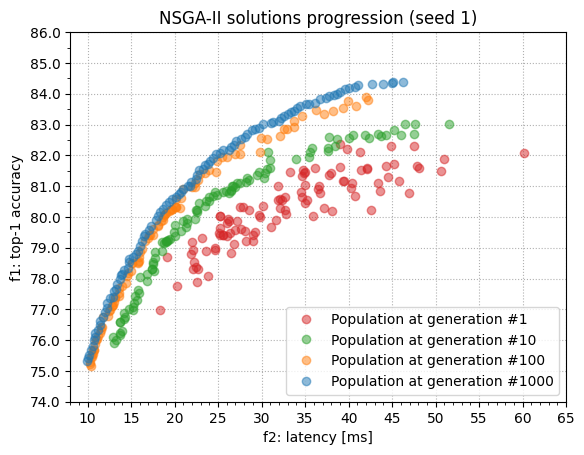

In [56]:
# NSGA-II population progression
x_min, x_max, y_min, y_max = 8, 65, 74, 86
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
gen0 = 0
gen1 = 9
gen2 = 99
gen3 = 999
ax.plot(ofa2_optimization_nsga2_seed1.history[gen0].pop.get('F')[:,0], 100 - ofa2_optimization_nsga2_seed1.history[gen0].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen0+1}', color=red,    alpha=0.5)
ax.plot(ofa2_optimization_nsga2_seed1.history[gen1].pop.get('F')[:,0], 100 - ofa2_optimization_nsga2_seed1.history[gen1].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen1+1}', color=green,  alpha=0.5)
ax.plot(ofa2_optimization_nsga2_seed1.history[gen2].pop.get('F')[:,0], 100 - ofa2_optimization_nsga2_seed1.history[gen2].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen2+1}', color=orange, alpha=0.5)
ax.plot(ofa2_optimization_nsga2_seed1.history[gen3].pop.get('F')[:,0], 100 - ofa2_optimization_nsga2_seed1.history[gen3].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen3+1}', color=blue,   alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('NSGA-II solutions progression (seed 1)'),
ax.legend()
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'nsga2_pop_progression.png')
# plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

### SMS-EMOA

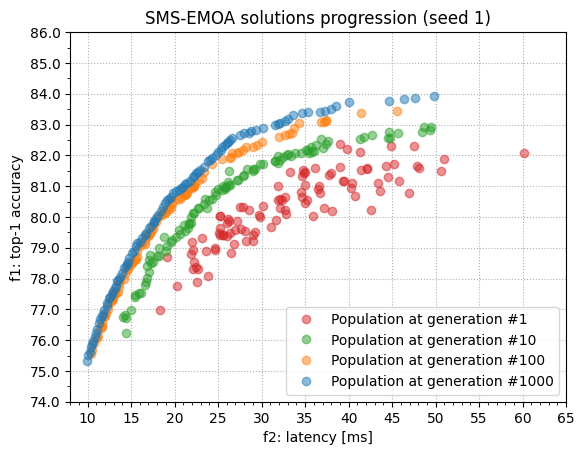

In [57]:
# SMS-EMOA population progression
x_min, x_max, y_min, y_max = 8, 65, 74, 86
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
gen0 = 0
gen1 = 9
gen2 = 99
gen3 = 999
ax.plot(ofa2_optimization_smsemoa_seed1.history[gen0].pop.get('F')[:,0], 100 - ofa2_optimization_smsemoa_seed1.history[gen0].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen0+1}', color=red,    alpha=0.5)
ax.plot(ofa2_optimization_smsemoa_seed1.history[gen1].pop.get('F')[:,0], 100 - ofa2_optimization_smsemoa_seed1.history[gen1].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen1+1}', color=green,  alpha=0.5)
ax.plot(ofa2_optimization_smsemoa_seed1.history[gen2].pop.get('F')[:,0], 100 - ofa2_optimization_smsemoa_seed1.history[gen2].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen2+1}', color=orange, alpha=0.5)
ax.plot(ofa2_optimization_smsemoa_seed1.history[gen3].pop.get('F')[:,0], 100 - ofa2_optimization_smsemoa_seed1.history[gen3].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen3+1}', color=blue,   alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('SMS-EMOA solutions progression (seed 1)'),
ax.legend()
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'smsemoa_pop_progression.png')
# plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

### SPEA2

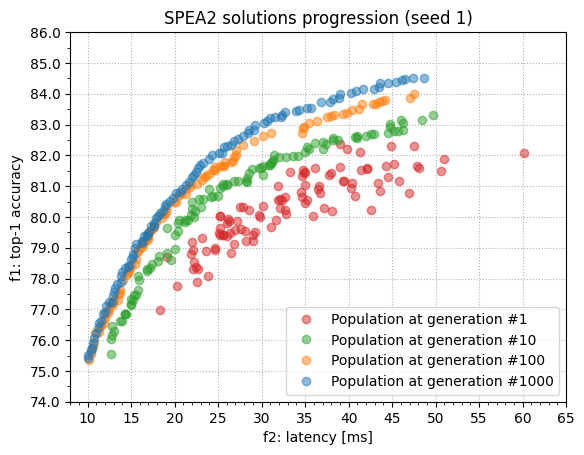

In [58]:
# SPEA2 population progression
x_min, x_max, y_min, y_max = 8, 65, 74, 86
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
gen1 = 0
gen1 = 9
gen2 = 99
gen3 = 999
ax.plot(ofa2_optimization_spea2_seed1.history[gen0].pop.get('F')[:,0], 100 - ofa2_optimization_spea2_seed1.history[gen0].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen0+1}', color=red,    alpha=0.5)
ax.plot(ofa2_optimization_spea2_seed1.history[gen1].pop.get('F')[:,0], 100 - ofa2_optimization_spea2_seed1.history[gen1].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen1+1}', color=green,  alpha=0.5)
ax.plot(ofa2_optimization_spea2_seed1.history[gen2].pop.get('F')[:,0], 100 - ofa2_optimization_spea2_seed1.history[gen2].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen2+1}', color=orange, alpha=0.5)
ax.plot(ofa2_optimization_spea2_seed1.history[gen3].pop.get('F')[:,0], 100 - ofa2_optimization_spea2_seed1.history[gen3].pop.get('F')[:,1], 'o', label=f'Population at generation #{gen3+1}', color=blue,   alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('SPEA2 solutions progression (seed 1)'),
ax.legend()
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'spea2_pop_progression.png')
# plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

## Seeds Comparison

### NSGA-II

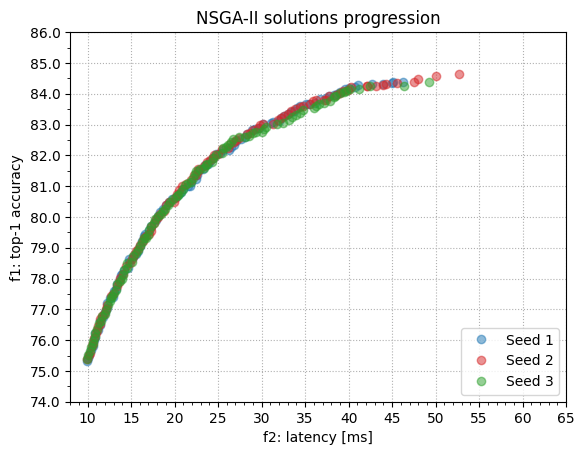

In [59]:
# NSGA-II seed comparison
x_min, x_max, y_min, y_max = 8, 65, 74, 86
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa2_optimization_nsga2_seed1.F[:,0], 100 - ofa2_optimization_nsga2_seed1.F[:,1], 'o', label='Seed 1', color=blue,  alpha=0.5)
ax.plot(ofa2_optimization_nsga2_seed2.F[:,0], 100 - ofa2_optimization_nsga2_seed2.F[:,1], 'o', label='Seed 2', color=red,   alpha=0.5)
ax.plot(ofa2_optimization_nsga2_seed3.F[:,0], 100 - ofa2_optimization_nsga2_seed3.F[:,1], 'o', label='Seed 3', color=green, alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('NSGA-II solutions progression'),
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'nsga2_seeds.png')
# plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

### SMS-EMOA

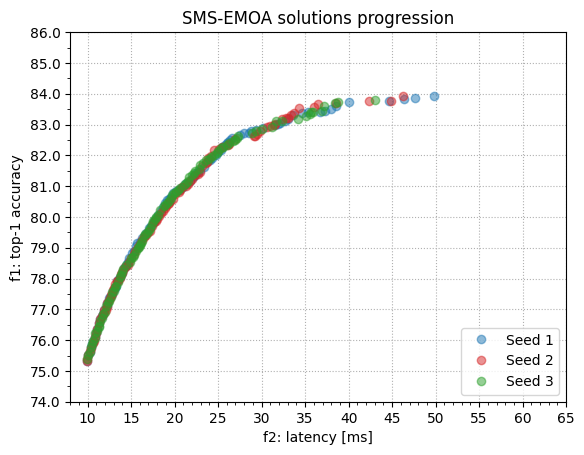

In [60]:
# SMS-EMOA seed comparison
x_min, x_max, y_min, y_max = 8, 65, 74, 86
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa2_optimization_smsemoa_seed1.F[:,0], 100 - ofa2_optimization_smsemoa_seed1.F[:,1], 'o', label='Seed 1', color=blue,  alpha=0.5)
ax.plot(ofa2_optimization_smsemoa_seed2.F[:,0], 100 - ofa2_optimization_smsemoa_seed2.F[:,1], 'o', label='Seed 2', color=red,   alpha=0.5)
ax.plot(ofa2_optimization_smsemoa_seed3.F[:,0], 100 - ofa2_optimization_smsemoa_seed3.F[:,1], 'o', label='Seed 3', color=green, alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('SMS-EMOA solutions progression'),
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'smsemoa_seeds.png')
# plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

### SPEA2

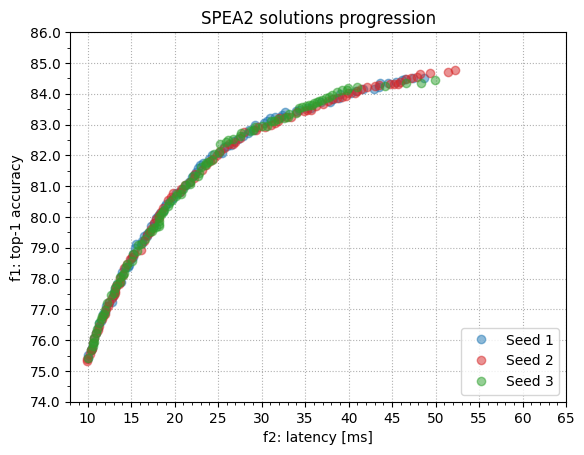

In [61]:
# SPEA2 seed comparison
x_min, x_max, y_min, y_max = 8, 65, 74, 86
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa2_optimization_spea2_seed1.F[:,0], 100 - ofa2_optimization_spea2_seed1.F[:,1], 'o', label='Seed 1', color=blue,  alpha=0.5)
ax.plot(ofa2_optimization_spea2_seed2.F[:,0], 100 - ofa2_optimization_spea2_seed2.F[:,1], 'o', label='Seed 2', color=red,   alpha=0.5)
ax.plot(ofa2_optimization_spea2_seed3.F[:,0], 100 - ofa2_optimization_spea2_seed3.F[:,1], 'o', label='Seed 3', color=green, alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('SPEA2 solutions progression'),
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'spea2_seeds.png')
# plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

## Final Population

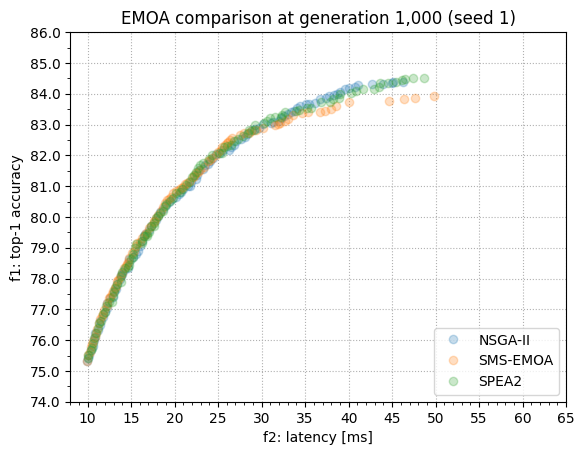

In [62]:
# EMOA comparison
x_min, x_max, y_min, y_max = 8, 65, 74, 86
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa2_optimization_nsga2_seed1.F[:,0],   100 - ofa2_optimization_nsga2_seed1.F[:,1],   'o', label='NSGA-II',  color=blue,   alpha=0.25)
ax.plot(ofa2_optimization_smsemoa_seed1.F[:,0], 100 - ofa2_optimization_smsemoa_seed1.F[:,1], 'o', label='SMS-EMOA', color=orange, alpha=0.25)
ax.plot(ofa2_optimization_spea2_seed1.F[:,0],   100 - ofa2_optimization_spea2_seed1.F[:,1],   'o', label='SPEA2',    color=green,  alpha=0.25)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('EMOA comparison at generation 1,000 (seed 1)'),
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'comparison_emoa_seed1.png')
# plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

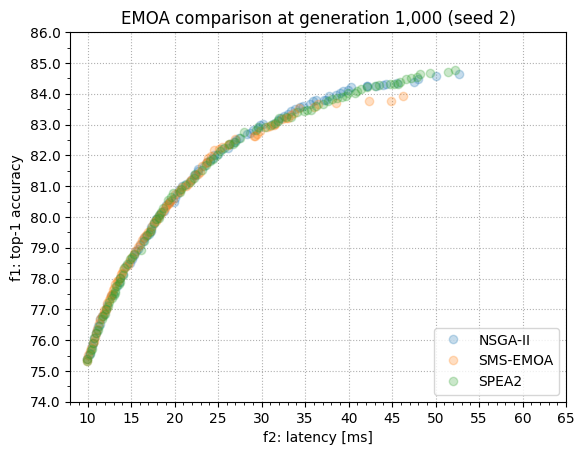

In [63]:
# EMOA comparison
x_min, x_max, y_min, y_max = 8, 65, 74, 86
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa2_optimization_nsga2_seed2.F[:,0],   100 - ofa2_optimization_nsga2_seed2.F[:,1],   'o', label='NSGA-II',  color=blue,   alpha=0.25)
ax.plot(ofa2_optimization_smsemoa_seed2.F[:,0], 100 - ofa2_optimization_smsemoa_seed2.F[:,1], 'o', label='SMS-EMOA', color=orange, alpha=0.25)
ax.plot(ofa2_optimization_spea2_seed2.F[:,0],   100 - ofa2_optimization_spea2_seed2.F[:,1],   'o', label='SPEA2',    color=green,  alpha=0.25)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('EMOA comparison at generation 1,000 (seed 2)'),
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'comparison_emoa_seed2.png')
# plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

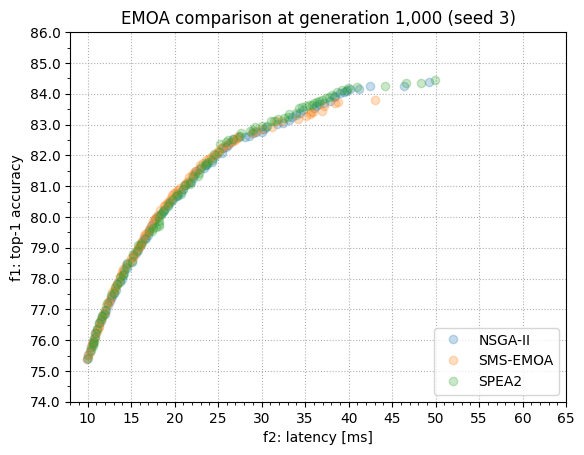

In [64]:
# EMOA comparison
x_min, x_max, y_min, y_max = 8, 65, 74, 86
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa2_optimization_nsga2_seed3.F[:,0],   100 - ofa2_optimization_nsga2_seed3.F[:,1],   'o', label='NSGA-II',  color=blue,   alpha=0.25)
ax.plot(ofa2_optimization_smsemoa_seed3.F[:,0], 100 - ofa2_optimization_smsemoa_seed3.F[:,1], 'o', label='SMS-EMOA', color=orange, alpha=0.25)
ax.plot(ofa2_optimization_spea2_seed3.F[:,0],   100 - ofa2_optimization_spea2_seed3.F[:,1],   'o', label='SPEA2',    color=green,  alpha=0.25)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('EMOA comparison at generation 1,000 (seed 3)'),
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'comparison_emoa_seed3.png')
# plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

## Hypervolume

In [65]:
ref_point = np.array([100, 25])
ind = HV(ref_point=ref_point)

In [66]:
ind = HV(ref_point=ref_point)
# NSGA-II
print('NSGA-II:')
print('HV', ind(ofa2_optimization_nsga2_seed1.history[0].pop.get('F')))
print('HV', ind(ofa2_optimization_nsga2_seed1.history[-1].pop.get('F')))
print('#-------------------------------------------------')
# SMS-EMOA
print('SMS-EMOA:')
print('HV', ind(ofa2_optimization_smsemoa_seed1.history[0].pop.get('F')))
print('HV', ind(ofa2_optimization_smsemoa_seed1.history[-1].pop.get('F')))
print('#-------------------------------------------------')
# SPEA2
print('SPEA2:')
print('HV', ind(ofa2_optimization_spea2_seed1.history[0].pop.get('F')))
print('HV', ind(ofa2_optimization_spea2_seed1.history[-1].pop.get('F')))

NSGA-II:
HV 555.624670421475
HV 751.5575521540798
#-------------------------------------------------
SMS-EMOA:
HV 555.624670421475
HV 722.0324047658767
#-------------------------------------------------
SPEA2:
HV 555.624670421475
HV 758.2705672527599


In [67]:
def calc_hypervolume(result):
    # N: number of generations
    N = len(result.history)
    hypervolume = [0] * N
    for i in range(N):
        hypervolume[i] = ind(result.history[i].pop.get('F'))
    # scale
    hypervolume -= hypervolume[0]
    return hypervolume

In [68]:
hypervolume_nsga2_seed1   = calc_hypervolume(ofa2_optimization_nsga2_seed1)
hypervolume_smsemoa_seed1 = calc_hypervolume(ofa2_optimization_smsemoa_seed1)
hypervolume_spea2_seed1   = calc_hypervolume(ofa2_optimization_spea2_seed1)
#-------------------------------------------------
hypervolume_nsga2_seed2   = calc_hypervolume(ofa2_optimization_nsga2_seed2)
hypervolume_smsemoa_seed2 = calc_hypervolume(ofa2_optimization_smsemoa_seed2)
hypervolume_spea2_seed2   = calc_hypervolume(ofa2_optimization_spea2_seed2)
#-------------------------------------------------
hypervolume_nsga2_seed3   = calc_hypervolume(ofa2_optimization_nsga2_seed3)
hypervolume_smsemoa_seed3 = calc_hypervolume(ofa2_optimization_smsemoa_seed3)
hypervolume_spea2_seed3   = calc_hypervolume(ofa2_optimization_spea2_seed3)

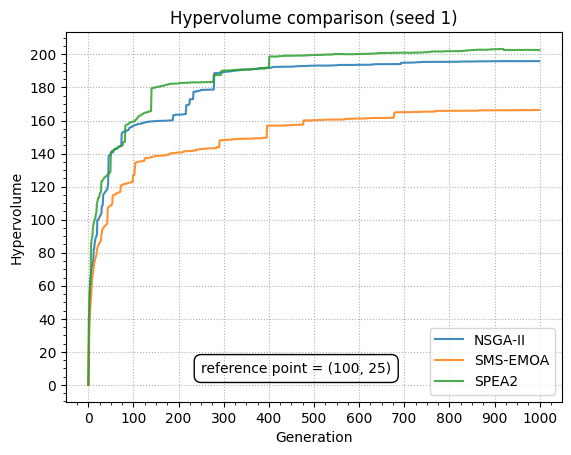

In [69]:
# Hypervolume comparison
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(hypervolume_nsga2_seed1,   color=blue,   alpha=0.85, label='NSGA-II')
ax.plot(hypervolume_smsemoa_seed1, color=orange, alpha=0.85, label='SMS-EMOA')
ax.plot(hypervolume_spea2_seed1,   color=green,  alpha=0.85, label='SPEA2')
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('Generation')
ax.set_ylabel('Hypervolume')
ax.set_title('Hypervolume comparison (seed 1)')
ax.text(250, 7.5, 'reference point = (100, 25)', color='black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(5))
#-------------------------------------------------
filename = os.path.join('figures', 'hypervolume_comparison_seed1.png')
#plt.savefig(filename)
fig.set_dpi(100)

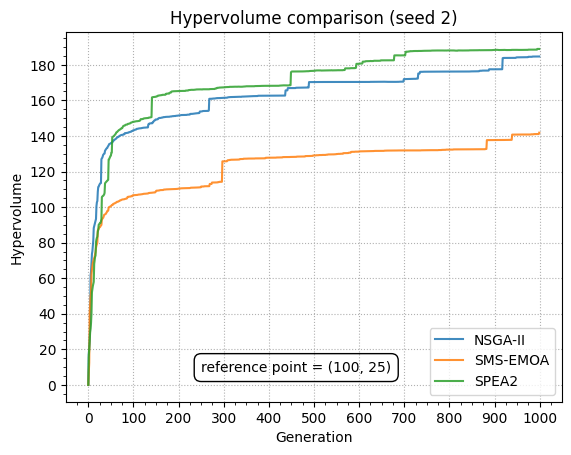

In [70]:
# Hypervolume comparison
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(hypervolume_nsga2_seed2,   color=blue,   alpha=0.85, label='NSGA-II')
ax.plot(hypervolume_smsemoa_seed2, color=orange, alpha=0.85, label='SMS-EMOA')
ax.plot(hypervolume_spea2_seed2,   color=green,  alpha=0.85, label='SPEA2')
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('Generation')
ax.set_ylabel('Hypervolume')
ax.set_title('Hypervolume comparison (seed 2)')
ax.text(250, 7.5, 'reference point = (100, 25)', color='black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(5))
#-------------------------------------------------
filename = os.path.join('figures', 'hypervolume_comparison_seed2.png')
#plt.savefig(filename)
fig.set_dpi(100)

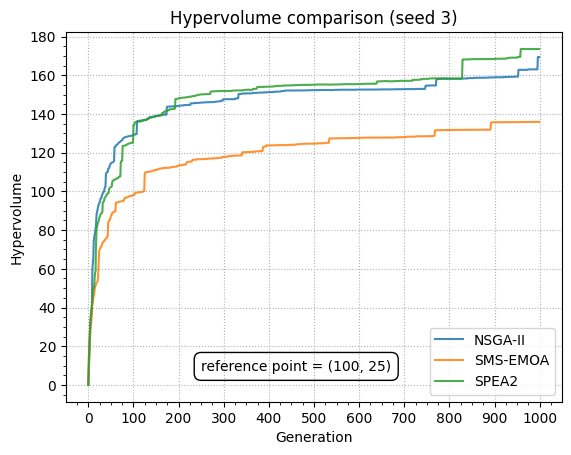

In [71]:
# Hypervolume comparison
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(hypervolume_nsga2_seed3,   color=blue,   alpha=0.85, label='NSGA-II')
ax.plot(hypervolume_smsemoa_seed3, color=orange, alpha=0.85, label='SMS-EMOA')
ax.plot(hypervolume_spea2_seed3,   color=green,  alpha=0.85, label='SPEA2')
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('Generation')
ax.set_ylabel('Hypervolume')
ax.set_title('Hypervolume comparison (seed 3)')
ax.text(250, 7.5, 'reference point = (100, 25)', color='black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(5))
#-------------------------------------------------
filename = os.path.join('figures', 'hypervolume_comparison_seed3.png')
#plt.savefig(filename)
fig.set_dpi(100)

# Save results

In [72]:
# Save history (optional)
#-------------------------------------------------
debug = False
#debug = True
if debug:
    # NSGA-II
    with open('ofa2_optimization_nsga2_seed1.pickle', 'wb') as f:
        pickle.dump(ofa2_optimization_nsga2_seed1, f)
    #---------------------------------------------
    # SMS-EMOA
    with open('ofa2_optimization_smsemoa_seed1.pickle', 'wb') as f:
        pickle.dump(ofa2_optimization_smsemoa_seed1, f)
    #---------------------------------------------
    # SPEA2
    with open('ofa2_optimization_spea2_seed1.pickle', 'wb') as f:
        pickle.dump(ofa2_optimization_spea2_seed1, f)

In [73]:
# Save optimization results (last population)
#-------------------------------------------------
debug = True
if debug:
    # NSGA-II
    with open('ofa2_nsga2.pickle', 'wb') as f:
        pickle.dump(res_nsga2_pop_seed1, f)
    #---------------------------------------------
    # SMS-EMOA
    with open('ofa2_smsemoa.pickle', 'wb') as f:
        pickle.dump(res_smsemoa_pop_seed1, f)
    #---------------------------------------------
    # SPEA2
    with open('ofa2_spea2.pickle', 'wb') as f:
        pickle.dump(res_spea2_pop_seed1, f)

# End of the notebook